## Abstract

## Introduction and Objectives

The Covid-19 pandemic started by the end of 2019, with an outbreak caused by Sars-Cov-2 in Wuhan, Hubei Province, China. A little more than two years later, we're still leading with this chaotic scenario through everyday life changes, such as the use of masks, social distancing and constant hand and public environments sanitation, besides having to adapt ourselves to the emergence of new virus variants as we expectantly await the advance of vaccines.

Currently, the most relevant variety is Omicron, which, despite being characterized by a low death rate, has a very high infection rate, bringing forth a huge amount of infected individuals, and, consequently, a death count that can't be ignored. Estimating the behavior of a virus is a mean of prevention and enables avoiding an even bigger tragedy, at the same time as it brings us steps for a gradient return to our normal lives.

In this project, we will try to explain the current condition of Covid-19 in Pernambuco, Brazil, as well as predict the pandemic's state by the end of July 2022. For such, we'll be using statistic and calculus knowledge to establish a reasonable epidemiological model, making use of Python libraries (NumPy, SciPy) to solve ODEs and making predictions based on the results, graphically represented with the aid of Matplotlib. Consequently, it will be an important practice of mathematical modeling for a real world problem.

## Methodology

The following is the ODE system we've elaborated thus far:

$$
    \frac{dS}{dt} = \frac{-\beta_I \cdot S \cdot (I_a + I_s)}{N} - \frac{\beta_E \cdot S \cdot E}{N} - \frac{\lambda(t) \cdot S}{N} + \frac{R}{\tau_{re}} \\
    \frac{dE}{dt} = \frac{\beta_I \cdot S \cdot (I_a + I_s)}{N} + \frac{\beta_E \cdot S \cdot E}{N} - \frac{E}{\tau} \\

    \frac{dI_a}{dt} = \frac{\rho \cdot E}{\tau} - \rho \cdot \gamma \cdot I_a \\
    \frac{dI_s}{dt} = (1 - \rho) \cdot E/\tau - (1-\rho) \cdot (\gamma + \mu) \cdot I_s \\

    \frac{dR}{dt} = \gamma \cdot I_a \cdot \rho + \gamma \cdot I_s \cdot (1 - \rho) - \lambda(t) \cdot R - \frac{R}{\tau_{re}} \\
    \frac{dD}{dt} = \mu \cdot I_s \cdot (1 - \rho) \\
    \frac{dV}{dt} = \frac{\lambda(t) \cdot S}{N} + \lambda(t) \cdot R \\
$$

Data was extracted considering the first day analyzed, that is, 1st February 2021 (01/02/2021):
- N (population); taken from [1];
- $CFR$ (Case Fatality Ratio); calculated from data in [1] (total cases and death count in Brazil) using the formula in [2]. It was assumed that the $CFR$ value for Pernambuco was the same as for Brazil;
- $\tau$ (mean incubation period), $\tau_r$ (mean time for recover) and $\tau_d$ (mean time for death); obtained from [3];
- $\gamma$ (mean recovery rate), $\mu$ (mean recovery rate); based on $CFR$, $\tau_r$ and $\tau_d$;
- $I_0$ (initial infected count); extracted from [4], considering that the actively infected population for that day was the amount of confirmed cases until then subtracted by death and recovery counts. Considering a small enough superposition, this data is taken as sufficiently accurate. Doesn't appear in the equation, but is used to determine $I_a$ and $I_s$ alongside $\rho$;
- $\rho$; taken from [5]. We'll be considering that 34.6% of the cases are asymptomatic;
- $\lambda(t)$; vaccination function.


In [149]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [150]:
# Total population of Pernambuco (as of 2021)
N = 9674793

# Initial number of infected
I0 = 21452

# Percentage of asymptomatic cases
rho = 0.346

# Initial number of infected (asymptomatic and symptomatic), recovered, exposed, dead and vaccinated individuals (01/02/2021)
Ia0, Is0, R0, E0, D0, V0 = I0 * rho, I0 * (1 - rho), 0, 0, 0, 0

# Everyone else, S0, is susceptible to infection initially
S0 = N - Ia0 - Is0 - R0 - E0 - D0 - V0

# Contact rate for infected and exposed individuals
beta_I, beta_E = 0.2, 0.1

# Case fatality ratio
cfr = 0.0242

# Average time for incubation, recovery, death and reinfection
tau = 5.1
tau_r, tau_d = 16, 13.8
tau_re = 365

# Mean recovery and death rates
gamma = (1 - cfr) / tau_r
mu =  cfr / tau_d

# A grid of time points (in days) for the first time period (01/02/2021 - 31/01/2022)
# Right now, it's serving as both time periods
t = np.linspace(0, 364 + 180, 365 + 180)

# # A grid of time points (in days) for the second time period (01/02/2022 - 31/07/2022)
# t2 = np.linspace(365, 365+180, 181)

In [151]:
# Vaccination rate
# Initital vaccination date in Pernambuco: 18/01/2021
def vaccination(t):
    return 0.005

In [152]:
def deriv(y, t):
    S, Ia,Is, R, E, D, V = y
    dSdt = -beta_I*S*(Ia + Is)/N - beta_E*S*E/N - vaccination(t) * S/N + R/tau_re
    dEdt = beta_I*S*(Ia + Is)/N + beta_E*S*E/N - E/tau
    dIadt = rho*E/tau - rho*gamma*Ia
    dIsdt = (1 - rho)*E/tau - (1-rho)*(gamma + mu)*Is
    dRdt = gamma * Ia * rho + gamma * Is * (1 - rho) - vaccination(t) * R - R/tau_re
    dDdt = mu * Is * (1 - rho)
    dVdt = vaccination(t) * S / N + vaccination(t) * R
    return dSdt, dIadt, dIsdt, dRdt, dEdt, dDdt, dVdt

In [153]:
# Initial conditions vector
y0 = S0, Ia0, Is0, R0, E0, D0, V0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t)
S, Ia,Is, R, E, D, V = ret.T

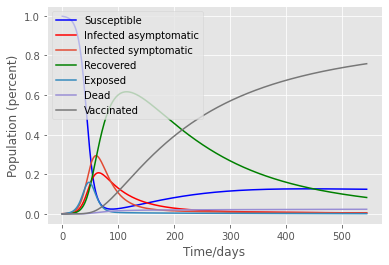

In [154]:
plt.plot(t, S/N, 'b', label='Susceptible')
plt.plot(t, Ia/N, 'r', label='Infected asymptomatic')
plt.plot(t, Is/N, label='Infected symptomatic')
plt.plot(t, R/N, 'g', label='Recovered')
plt.plot(t, E/N, label='Exposed')
plt.plot(t, D/N, label='Dead')
plt.plot(t, V/N, label='Vaccinated')
plt.xlabel('Time/days')
plt.ylabel('Population (percent)')
plt.legend()
plt.show()

## Results and Discussions

As it stands right now, we don't have a scientific base to define the values of the contact rates $\beta$, and so the current modeling doesn't reflect the pandemic in the right intensity and duration. However, we're sufficiently happy with the way the graph is behaving.

Moreover, we're considering that vaccinated individuals are completely immune to the disease, which doesn't happen in reality. As such, we'll be further separating the vaccinated group according to the amount of doses one person has taken up to that moment. For the first dose, we'll ideally work with an accumulated distribution function (right now we have a placeholder) to mimic the vaccination rates seen in the analyzed period. For the following ones, we'll consider $\tau_{v2}$ and $\tau_{vr}$, the mean time between the first and second doses and the one between the second and reinforcement doses, respectively. Also, each vaccinated group will ideally have a different $\beta$ and $\mu$.

Given that all the above parameters are properly implemented, we'll be working towards defining new waves, which we theorize happen during periods of high social stress, mainly related to country-wide festivities, such as Christmas and New Year. Those waves are also related to new variants of the virus, their spread augmented in the festivities period.

## Conclusion


Currently, our model isn't adopting certain parameters with their adequate value. This is visually perceptible as we analyze aspects as death count, infected peak, and, specially, curves stabilization (they stabilize before the current moment). This last one evidences the importance of considering the social perception of the pandemic and how this affects the contact level between people, as well as the emergence of new Covid-19 variants, those being factors that were responsible for creating a new cases crescent in January 2022.

## References
[1] [Vacinômetro - Brasil](https://www.worldometers.info/coronavirus/country/brazil/)</br>
[2] [WHO - Estimating mortality from COVID-19](https://www.who.int/news-room/commentaries/detail/estimating-mortality-from-covid-19) </br>
[3] [Estimative of real number of infections by COVID-19 on Brazil and possible scenarios](https://www.medrxiv.org/content/10.1101/2020.05.03.20052779v3) </br>
[4] [Painel de casos de doença pelo coronavírus 2019 (COVID-19) em Pernambuco, no Brasil e no Mundo.](https://dados.seplag.pe.gov.br/apps/corona.html#geral) </br>
[5] [Estimating the Asymptomatic Ratio of 2019 Novel Coronavirus onboard the Princess Cruises Ship, 2020](https://www.medrxiv.org/content/10.1101/2020.02.20.20025866v1.full.pdf) </br>
[6] [IBGE - Panorama Pernambuco](https://cidades.ibge.gov.br/brasil/pe/panorama)